# Проект - Рекомендация тарифов
### Цель проекта: построить модель для задачи классификации, которая выберет подходящий тариф с долей правильных ответов не менее 75%
- **Описание данных**
- Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).
- **Дополнительные шаги исследования:**
1. Разделите исходные данные на обучающую, валидационную и тестовую выборки.
2. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.
3. Проверьте модель на тестовой выборке
4. Проверьте модели на вменяемость

In [1]:
#импортируем нужные для исследования библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

pd.options.display.float_format = '{:.2f}'.format
sns.set_style('darkgrid')
plt.figsize=(10, 7)

In [2]:
#загрузим данные
server_path = '/datasets/users_behavior.csv'
local_path = 'users_behavior.csv'
try:
    df = pd.read_csv(server_path)
except: 
    df = pd.read_csv(local_path)

# 1. Знакомство с данными

In [3]:
#посмотрим общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
#проверим пропуски
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [5]:
#посмотрим размер таблицы
df.shape

(3214, 5)

In [6]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

- По заданию предобработка не требуется. В итоге имеем 3214 объектов и 5 признаков. Так же можно заметить что классы отличаются размером друг от друга примерно в 2 раза

# 2. Разделите исходные данные на обучающую, валидационную и тестовую выборки

In [7]:
# features-все признаки кроме целевого, target-целевой признак
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [8]:
#все признаки 
features

,calls,minutes,messages,mb_used
0,40.00,311.90,83.00,19915.42
1,85.00,516.75,56.00,22696.96
2,77.00,467.66,86.00,21060.45
3,106.00,745.53,81.00,8437.39
4,66.00,418.74,1.00,14502.75
...,...,...,...,...
3209,122.00,910.98,20.00,35124.90
3210,25.00,190.36,0.00,3275.61
3211,97.00,634.44,70.00,13974.06
3212,64.00,462.32,90.00,31239.78


In [9]:
#посмотрим корреляцию
features.corr()

,calls,minutes,messages,mb_used
calls,1.00,0.98,0.18,0.29
minutes,0.98,1.00,0.17,0.28
messages,0.18,0.17,1.00,0.20
mb_used,0.29,0.28,0.20,1.00


**Вывод:**
- Видно что присутствует мультиколлинеарность, звонок и минуты очень сильно коррелируют, это отразиться на обучении моделей, удалим признак минуты

In [10]:
features = features.drop('minutes', axis=1)

In [11]:
#целевой признак 
target

0       0
1       0
2       0
3       1
4       0
       ..
3209    1
3210    0
3211    0
3212    0
3213    1
Name: is_ultra, Length: 3214, dtype: int64

In [12]:
#разделим выборки 
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [13]:
#обучающая выборка, валидационная
print('Размер обучающей:',X_train.shape,y_train.shape)
print('Размер тестовой:',X_test.shape,y_test.shape)
print('Размер валидационной:',X_val.shape,y_val.shape)

Размер обучающей: (1928, 3) (1928,)
Размер тестовой: (643, 3) (643,)
Размер валидационной: (643, 3) (643,)


In [14]:
#Размер обучающей, валидационная, тестовая
1928/3214, 643/3214, 643/3214

(0.5998755444928439, 0.2000622277535781, 0.2000622277535781)

- Разделили выборки в соотношении 60:20:20, можем приступать к тестированию моделей. Валидационная выборка нам нужна для того, чтобы как можно лучше настроить модель, а уже итоговое качество оценить по тестовой выборке

In [15]:
# проверка на пересечение
display(set(X_train.index) & set(X_test.index), set(X_test.index) & set(X_val.index))

set()

set()

# 3. Решающее дерево

Глубина: 1 Accuracy: 0.7418351477449455
Глубина: 2 Accuracy: 0.7620528771384136
Глубина: 3 Accuracy: 0.7853810264385692
Глубина: 4 Accuracy: 0.7962674961119751
Глубина: 5 Accuracy: 0.7884914463452566
Глубина: 6 Accuracy: 0.7853810264385692
Глубина: 7 Accuracy: 0.7900466562986003
Глубина: 8 Accuracy: 0.7884914463452566
Глубина: 9 Accuracy: 0.776049766718507
Глубина: 10 Accuracy: 0.7791601866251944


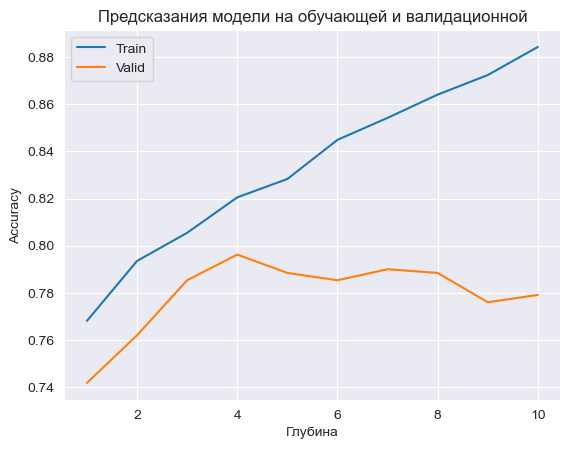


Accuracy лучшей модели: 0.7962674961119751 с глубиной: 4


In [16]:
#посмотрим на модель с разной глубиной
tree_m = []
tree_depth = []
tree_valid = []
for depth in range(1, 10+1):
    model = DecisionTreeClassifier(random_state=1, max_depth=depth) 
    model.fit(X_train, y_train) 
    predictions = model.predict(X_val)
    train_predictions = model.predict(X_train)
    result = accuracy_score(y_val, predictions)
    accuracy_test = accuracy_score(y_train, train_predictions)# замеряем точность на обучающей
    print('Глубина:', depth, 'Accuracy:',result)
    tree_m.append(result)
    tree_depth.append(depth)
    tree_valid.append(accuracy_test)

sns.lineplot(data=pd.Series(data=tree_valid, index=tree_depth), legend=True, label='Train')
sns.lineplot(data=pd.Series(data=tree_m, index=tree_depth), legend=True,label='Valid')
plt.title('Предсказания модели на обучающей и валидационной')
plt.ylabel('Accuracy')
plt.xlabel('Глубина')
plt.show()
print()        
print("Accuracy лучшей модели:", max(tree_m), 'с глубиной:', np.argmax(tree_m)+1)

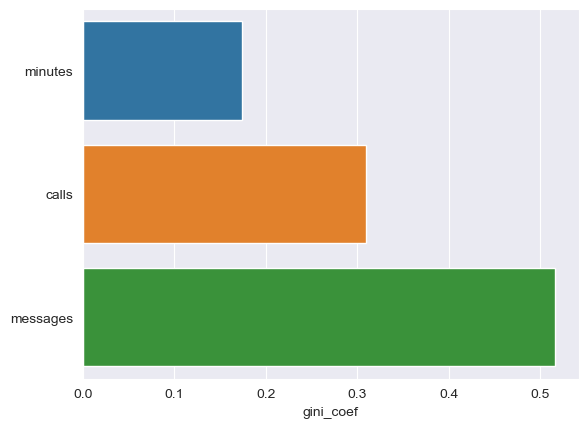

In [17]:
#ради интереса посмотрим, какой признак для модели важнее всего
feats = {}
for feature,importace in zip(df,model.feature_importances_):
    feats[feature] = importace
data = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'gini_coef'}).sort_values(by='gini_coef')
#построим диаграмму
sns.barplot(data=data,x='gini_coef',y=data.index);

**Вывод:**
- Доля верных ответов у дерева решений лучше всего на глубине 9, запомним это и посмотрим на другие модели, так же наиболее важным признаком модель считает использование интернета

# 4. Случайный лес

In [18]:
#посмотрим на долю верных ответов при разном кол-ве деревьев
rf_m = []
rf_before =[]
for est in range(1, 50+1, 3):
    model = RandomForestClassifier(random_state=1, n_estimators=est) 
    model.fit(X_train, y_train)  
    predictions = model.predict(X_val) 
    result = accuracy_score(y_val, predictions)
    rf_m.append(result)
    rf_before.append(est)
    print('Деревьев:', est,'', 'Accuracy:',result)
print()
print('Accuracy лучшей модели:',max(rf_m))

Деревьев: 1  Accuracy: 0.7231726283048211
Деревьев: 4  Accuracy: 0.7791601866251944
Деревьев: 7  Accuracy: 0.7869362363919129
Деревьев: 10  Accuracy: 0.807153965785381
Деревьев: 13  Accuracy: 0.8133748055987559
Деревьев: 16  Accuracy: 0.8055987558320373
Деревьев: 19  Accuracy: 0.8087091757387247
Деревьев: 22  Accuracy: 0.8102643856920684
Деревьев: 25  Accuracy: 0.8040435458786936
Деревьев: 28  Accuracy: 0.8102643856920684
Деревьев: 31  Accuracy: 0.7993779160186625
Деревьев: 34  Accuracy: 0.807153965785381
Деревьев: 37  Accuracy: 0.80248833592535
Деревьев: 40  Accuracy: 0.8055987558320373
Деревьев: 43  Accuracy: 0.8040435458786936
Деревьев: 46  Accuracy: 0.8055987558320373
Деревьев: 49  Accuracy: 0.8040435458786936

Accuracy лучшей модели: 0.8133748055987559


**Вывод**
- Доля верных ответов лучше всего при 13 деревьях

In [19]:
#тестируем случайный лес с разной глубиной и разным количеством деревьев
rf_m = []
rf_est = []
best_model = None
best_result = 0
for est in range(1, 50+1, 3):
    for depth in range (1, 10+1):
        model = RandomForestClassifier(random_state=1, n_estimators=est,max_depth=depth) 
        model.fit(X_train, y_train) 
        predictions = model.predict(X_val) 
        result = accuracy_score(y_val, predictions)
        rf_m.append(result)
        rf_est.append(est)
        if result > best_result:
            best_result = result
            best_model = model
        
            
print(best_model)
print('Accuracy лучшей модели:',max(rf_m))

RandomForestClassifier(max_depth=10, n_estimators=16, random_state=1)
Accuracy лучшей модели: 0.8180404354587869


### Изучим GridSearch

In [20]:
#создадим модель
rfc = RandomForestClassifier(random_state=1)
#создаём словарь в котором будут содержаться условия которые будут тестироваться с помощью GridSearch
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 7),
              'min_samples_leaf': range (1,5),
              'min_samples_split': range (2,10,2)}

In [21]:
#запускаем обучение
grid = GridSearchCV(rfc, parametrs, cv=5,verbose = 5, n_jobs=-1)
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(1, 7),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 51, 10)},
             verbose=5)

In [22]:
#посмотрим какие параметры подобрал этот механизм
grid.best_params_

{'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [23]:
#посмотрим оценку
grid.best_score_

0.8091285916156382

In [24]:
#лучшая модель
grid.best_estimator_

RandomForestClassifier(max_depth=6, n_estimators=50, random_state=1)

**Вывод**
- Используя инструмент GridSearchCV, подобрали наилучшие параметры для модели, проверим её на тестовой выборке
- Лучшие настройки:
  - min_samples_leaf: минимальное количество выборок в листе - 3
  - min_samples_split: минимальное количество разделений в условии - 2
  - max_depth: глубина дерева 4
  - n_estimators: кол-во деревьев 50

# 5. Логистическая регрессия

In [25]:
#попробуем логистическую регрессию 
log = []
model = LogisticRegression(random_state=1,solver='lbfgs',max_iter=2000) 
model.fit(X_train, y_train)
predictions = model.predict(X_val)
result = accuracy_score(y_val, predictions)
log.append(result)

print('Accuracy:',max(log))

Accuracy: 0.6796267496111975


# 6.Сравнение моделей

In [26]:
#для сравнения создадим таблицу
check = pd.DataFrame(columns=['tree', 'forest', 'log_reg'])
check['tree_accuracy'] = pd.Series(tree_m)
check['tree_depth'] = pd.Series(tree_depth)
forest_df = pd.DataFrame(data=rf_m,index=rf_est).rename(columns={0: 'forest_accuracy'})

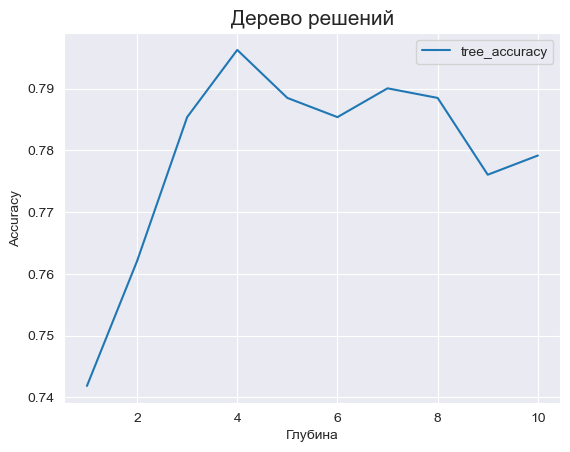

In [27]:
#посмотрим на дерево решений и оценку точности при разной глубине
check.plot(kind='line',y='tree_accuracy',x='tree_depth')
plt.title('Дерево решений', fontsize=15) 
plt.ylabel('Accuracy') 
plt.xlabel('Глубина')
plt.show()

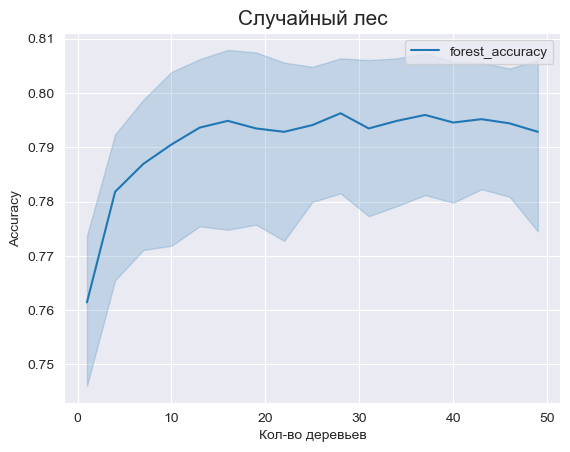

In [28]:
#посмотрим график
sns.lineplot(data=forest_df)
plt.title('Случайный лес', fontsize=15) 
plt.ylabel('Accuracy') 
plt.xlabel('Кол-во деревьев')
plt.show()

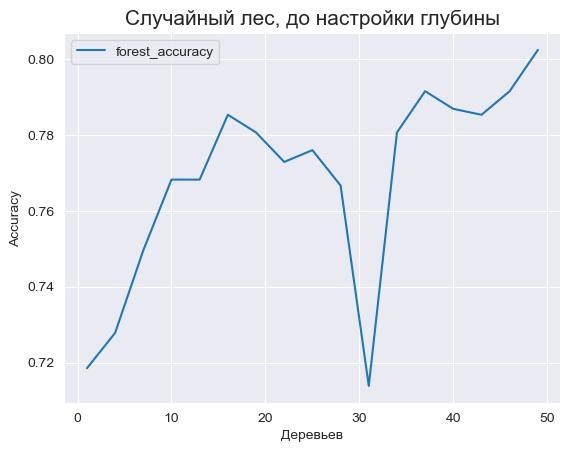

In [29]:
#случайный лес до настройки глубины
forest_before = pd.DataFrame(columns=['forest_accuracy','forest_est'])
forest_before['forest_accuracy']= pd.Series(rf_m)
forest_before['forest_est']= pd.Series(rf_before)

#Случайный лес
forest_before.plot(kind='line',y='forest_accuracy',x='forest_est')
plt.title('Случайный лес, до настройки глубины', fontsize=15) 
plt.ylabel('Accuracy') 
plt.xlabel('Деревьев')
plt.show()

**Вывод**
- Случайный лес доля верных ответов лучше всего при 46 деревьях 
- 2 Место у решающего дерева при глубине 4
- Логистическая регрессия думаю может лучше, когда научусь настраивать)

# 7. Проверьте модель на тестовой выборке

In [30]:
#пробуем модель на тестовой 
model = RandomForestClassifier(max_depth=9, n_estimators=28,random_state=1)
model.fit(X_train, y_train) 
predictions = model.predict(X_test) 
result = accuracy_score(y_test, predictions)
print('Результат модели на тестовой выборке:',result)

Результат модели на тестовой выборке: 0.7916018662519441


### Протестируем модель настроенную с помощью GridSearch

In [31]:
#тестируем модель на выборке
rfc_test = grid.best_estimator_
rfc_test.fit(X_train, y_train)# обучаем на обучающей выборке
test_pred = rfc_test.predict(X_test)# пробуем на тестовой
res_rfc = accuracy_score(y_test, test_pred)
print('Результат модели на тестовой выборке с GridSearch:',res_rfc)

Результат модели на тестовой выборке с GridSearch: 0.776049766718507


# 8. Sanity check

In [32]:
df['is_ultra'].value_counts(normalize=True)

0   0.69
1   0.31
Name: is_ultra, dtype: float64

**Вывод:**
- Если мы бы предсказывали константой, то точность такой модели 0.69, точность нашей модели 0.79

# Общий вывод
- Познакомились с данными, устранили мультиколлинеарность
- Разделили данные на train/test/valid
- Изучили различные модели и их гиперпараметры
- Попробовали настроить гиперпараметры
- **Модель случайный лес с глубиной 9 и кол-вом деревьев 28, показал результат на тестовой выборке 0.79, что является выше минимального порого 0.75**